# Climate and vegetation

- Variables are: `NDVI_mm`, `SWVL1_mm`, `STL1_mm`, `WB_mm`, `WD_mm`, `TP_mm`, `E_mm`, `RELHUM_mm`, `SSR_mm`, and `T2M_mm`.
- `Spearman rank correlation` between vegetation and climate variables with and without lags.
- Lags are 1, 2, 3, and 6.
- Local analysis for Manaus.
    - Plot time series.
    - Autocorrelation.
    - Pair plots.

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
# Load packages.
import sys
import glob
import progressbar

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

/home/alex/anaconda3/envs/machine36/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/alex/anaconda3/envs/machine36/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
# First we will use cartopy's shapereader to download (and cache) 
# states shapefile with 50 meters resolution from the NaturalEarth.
kw = dict(
    resolution="50m", 
    category="cultural", 
    name="admin_1_states_provinces"
)
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [5]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [6]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn
from cdlearn.auxiliary import dict_units, dict_titles_pt

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Time range. The same as GIMMS ndvi.
ti, tf = "1981-07", "2015-12"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

## 2 Load monthly observed data

In [7]:
%%time

# Monthly means (mm).
var_labels = [
    "NDVI_mm", 
    "SWVL1_mm", 
    "STL1_mm", 
    "WB_mm",
    "WD_mm",
    "TP_mm", 
    "E_mm", 
    "RELHUM_mm", 
    "SSR_mm", 
    "T2M_mm"
]

codes = [
    "ndvi", 
    "swvl1", 
    "stl1", 
    "wb",
    "wd",
    "tp", 
    "e", 
    "relhum", 
    "ssr", 
    "t2m"
]

# South America.
region = {
    "loni": loni, 
    "lonf": lonf, 
    "lati": lati, 
    "latf": latf
}

# The same as GIMMS ndvi.
time_range = {
    "ti": ti, 
    "tf": tf
}

verbose = False
cd = cdlearn.pixels.ClimateData(
    var_labels=var_labels, 
    region=region,
    time_range=time_range,
    verbose=verbose
)

CPU times: user 12.5 s, sys: 161 ms, total: 12.6 s
Wall time: 12.9 s


**DANGER ZONE! Memory intensive operation**

In [8]:
%%time

DSs = cd.load_into_memory(verbose=verbose)

CPU times: user 32.1 s, sys: 3.77 s, total: 35.8 s
Wall time: 38.8 s


## 3 Nonlinear correlations between variables (monthly data)

In [9]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=0,method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 9s, sys: 2.16 s, total: 1min 11s
Wall time: 1min 9s


CPU times: user 7.99 s, sys: 94.1 ms, total: 8.08 s
Wall time: 8.16 s


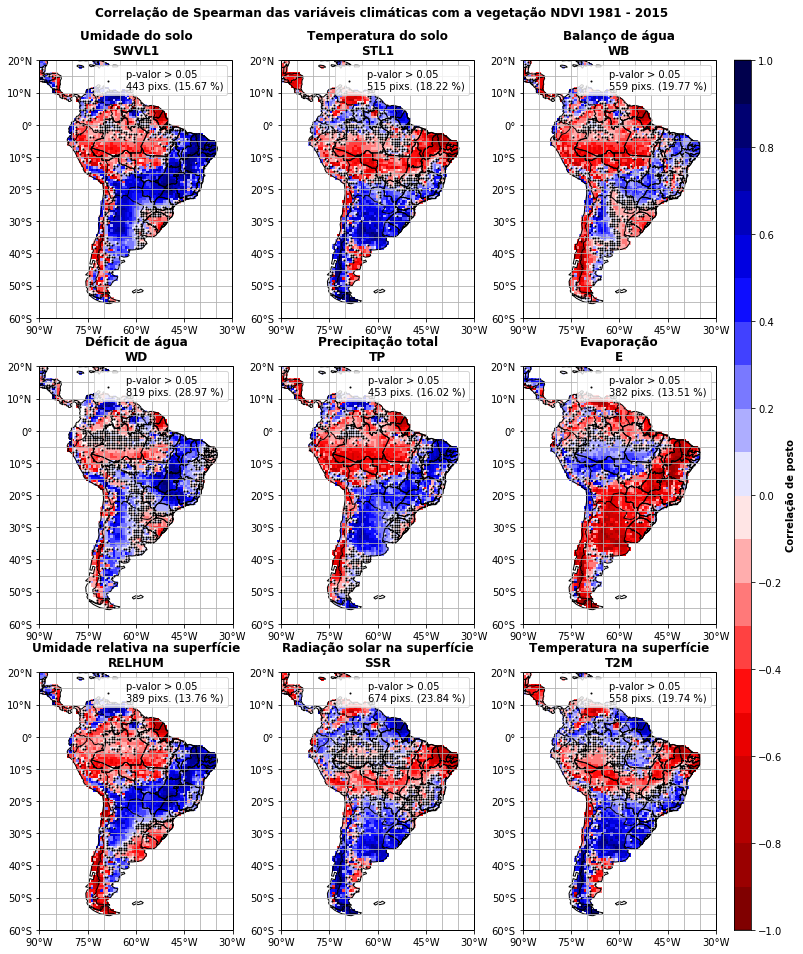

In [10]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar na superfície\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das variáveis climáticas com a vegetação NDVI" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_pt.jpg", dpi=200, bbox_inches="tight")

In [11]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=1, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 3s, sys: 1.68 s, total: 1min 4s
Wall time: 1min 2s


CPU times: user 6.32 s, sys: 108 ms, total: 6.42 s
Wall time: 6.42 s


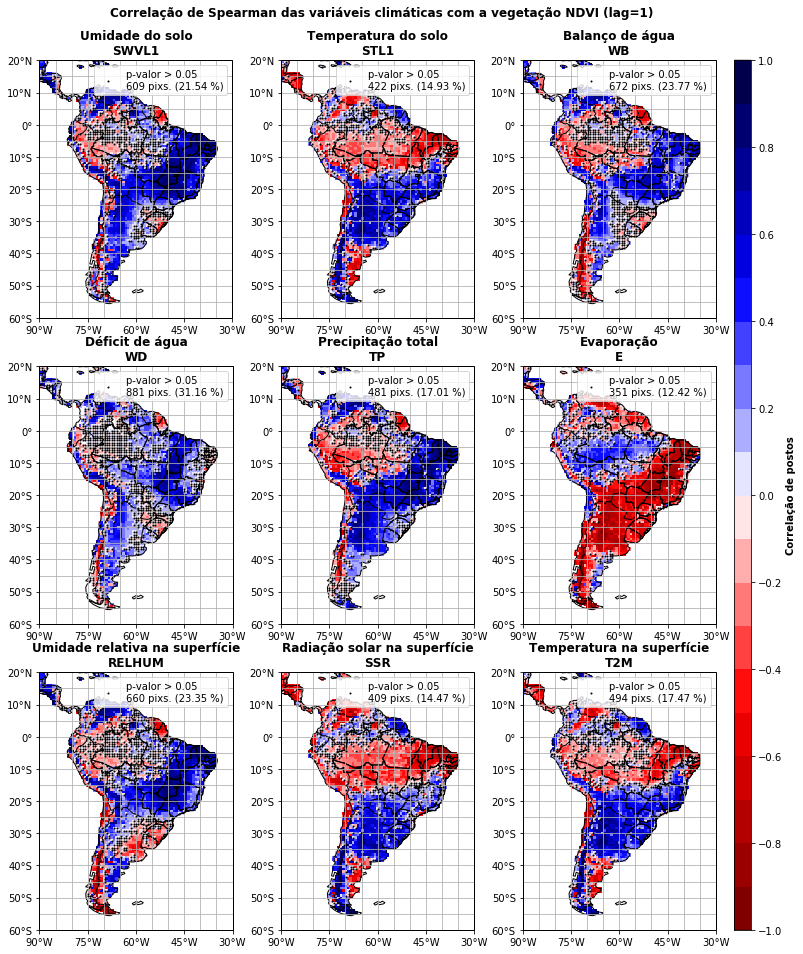

In [12]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de postos", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das variáveis climáticas com a vegetação NDVI" + \
             " (lag=1)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag1_pt.jpg", dpi=200, bbox_inches="tight")

In [13]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=2, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 56.1 s, sys: 376 ms, total: 56.4 s
Wall time: 54.6 s


CPU times: user 6.61 s, sys: 83.9 ms, total: 6.69 s
Wall time: 6.74 s


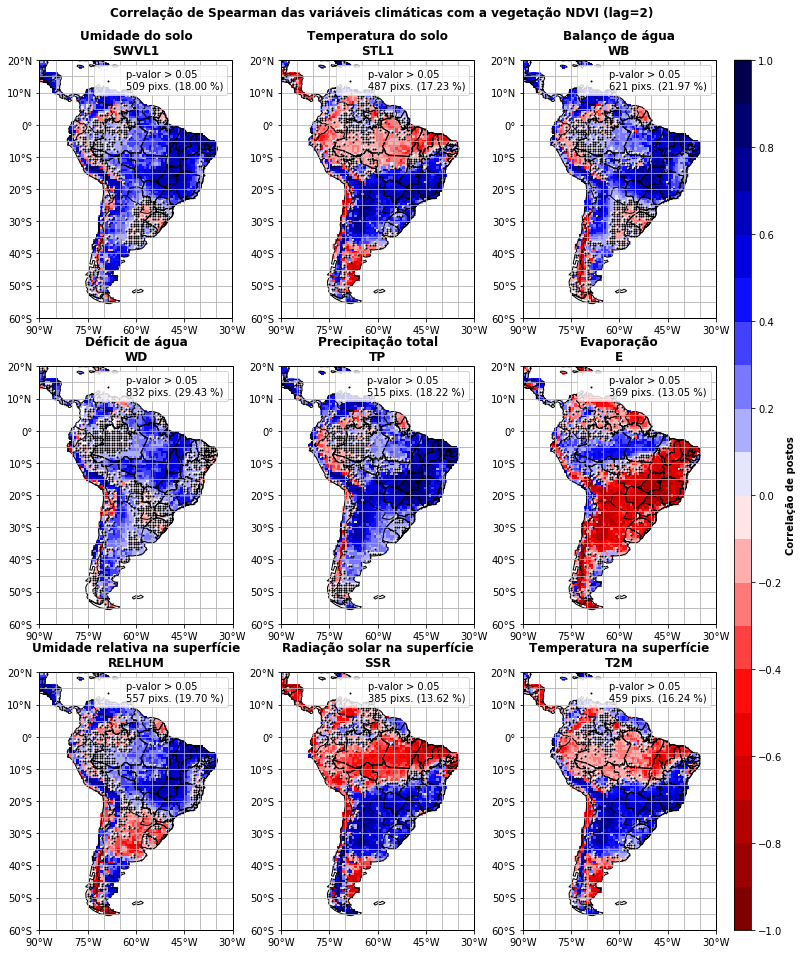

In [14]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de postos", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das variáveis climáticas com a vegetação NDVI" + \
             " (lag=2)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag2_pt.jpg", dpi=200, bbox_inches="tight")

In [15]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=3, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 1s, sys: 676 ms, total: 1min 1s
Wall time: 1min


CPU times: user 9.29 s, sys: 160 ms, total: 9.45 s
Wall time: 9.7 s


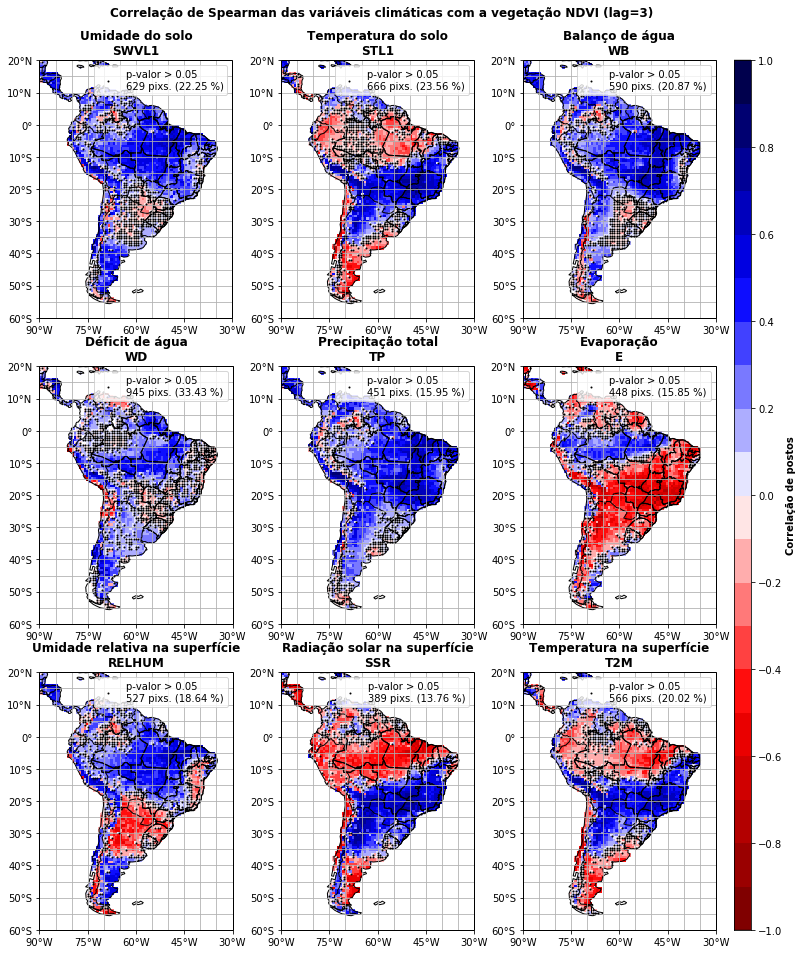

In [16]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de postos", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das variáveis climáticas com a vegetação NDVI" + \
             " (lag=3)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag3_pt.jpg", dpi=200, bbox_inches="tight")

In [17]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=6, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 9s, sys: 484 ms, total: 1min 9s
Wall time: 1min 7s


CPU times: user 7.16 s, sys: 112 ms, total: 7.27 s
Wall time: 7.29 s


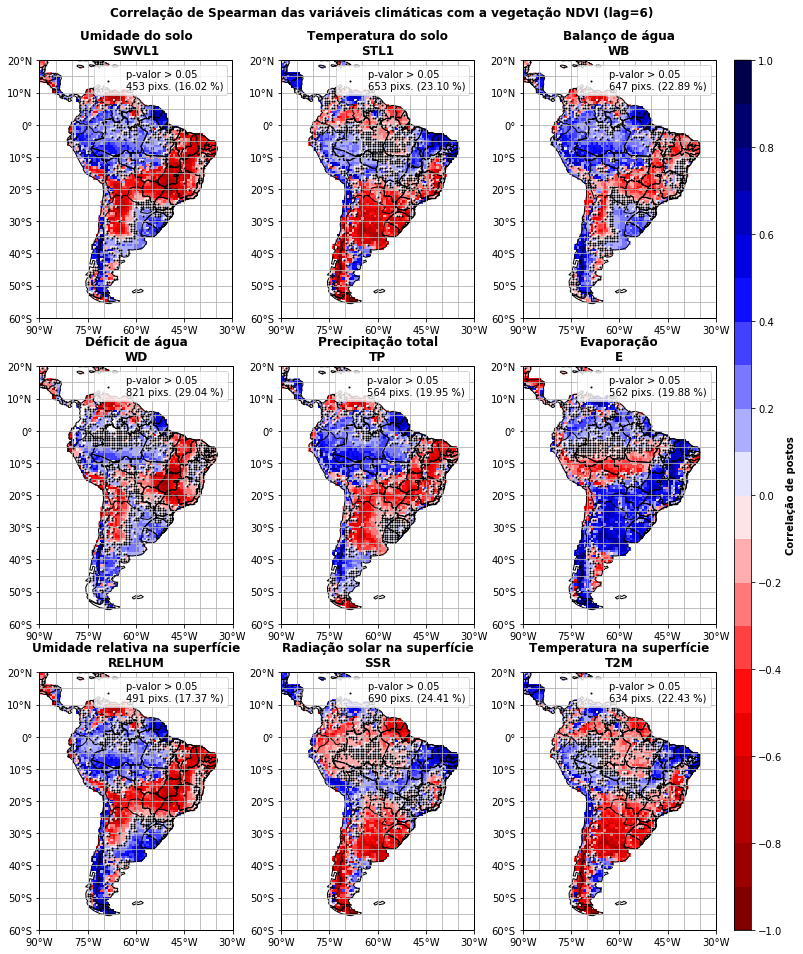

In [18]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de postos", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das variáveis climáticas com a vegetação NDVI" + \
             " (lag=6)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag6_pt.jpg", dpi=200, bbox_inches="tight")

## 4 Local analysis for Manaus

### 4.1 Time series

In [19]:
%%time

# Make dictionary for retrieving data. 
var_dict = {}
for var_label, var_code in zip(var_labels, codes):
    var_dict[var_label] = var_code

# Manaus location.
location = "Manaus"
pix_lat = -3
pix_lon = -60

# Make pandas DataFrame object for local data.
df_local = cd.extract_monthly_means_time_series(
    var_dict=var_dict,
    pix_lat=pix_lat,
    pix_lon=pix_lon
)

# Show it.
df_local.head()

CPU times: user 29.1 s, sys: 2.16 s, total: 31.2 s
Wall time: 30.4 s


,NDVI_mm,SWVL1_mm,STL1_mm,WB_mm,WD_mm,TP_mm,E_mm,RELHUM_mm,SSR_mm,T2M_mm
1981-07-01,0.715593,0.309639,299.496429,-0.000583,-0.000583,0.002965,-0.003548,93.527519,15159808.0,299.023926
1981-08-01,0.702939,0.290634,300.447906,-0.000966,-0.001549,0.002699,-0.003665,93.544731,16422400.0,299.812531
1981-09-01,0.700777,0.291939,300.632690,-0.000517,-0.002066,0.003360,-0.003876,93.825813,17181440.0,299.840393
1981-10-01,0.690589,0.291672,301.381226,-0.000697,-0.002763,0.003443,-0.004140,93.003265,18251264.0,300.730133
1981-11-01,0.587264,0.298546,301.232788,0.001113,-0.001650,0.005115,-0.004002,94.663826,16742400.0,300.316895


CPU times: user 3.72 s, sys: 67.8 ms, total: 3.78 s
Wall time: 3.93 s


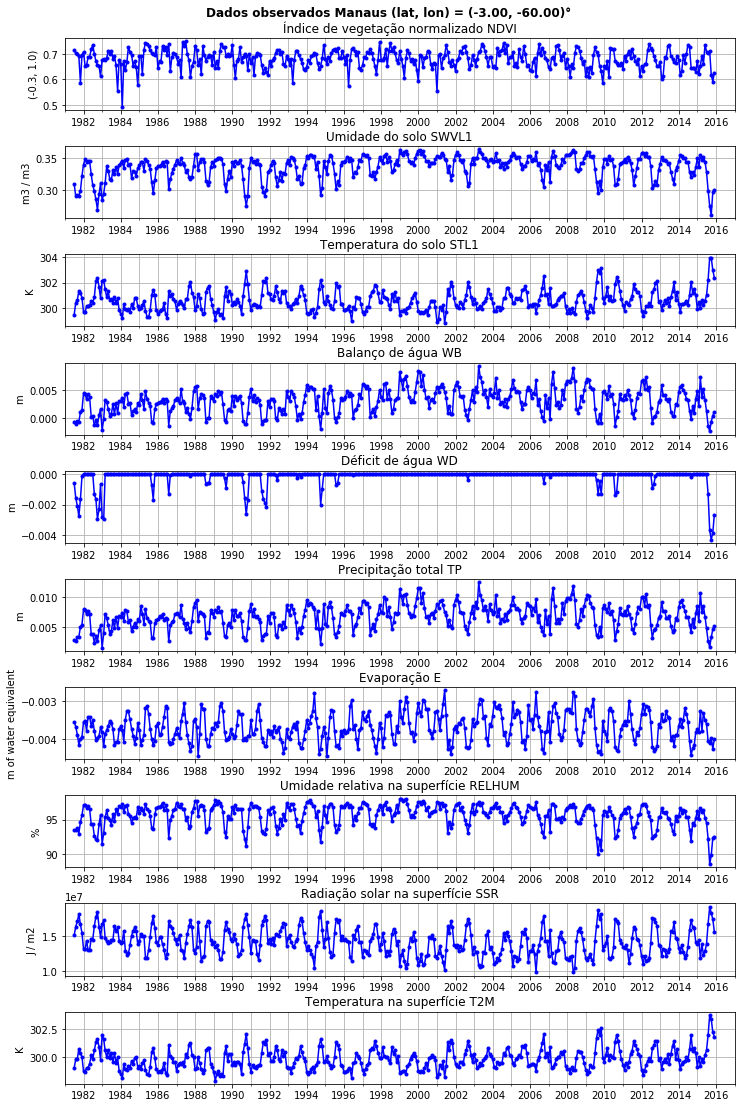

In [20]:
%%time

# Plot all time series.
cols = df_local.columns
fig, axes = plt.subplots(ncols=1, nrows=cols.size, figsize=(12, cols.size * 1.75))
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

for index, var_label in enumerate(var_dict.keys()):
    code = var_dict[var_label]
    axes[index].plot(df_local.index, df_local.loc[:, var_label], ".-b")
    axes[index].set_title(dict_titles_pt[code])
    axes[index].set_xlim(pd.Timestamp("1981"), pd.Timestamp("2017"))
    axes[index].set_xticks(pd.date_range(start="1981", end="2017", freq="1YS"), minor=True)    
    axes[index].xaxis.set_major_locator(years)
    axes[index].xaxis.set_major_formatter(years_fmt) 
    axes[index].grid(which="both")
    axes[index].set_ylabel(dict_units[code])

# Further adjustments.
plt.suptitle("Dados observados Manaus (lat, lon) = (%.2f, %.2f)°" %(pix_lat, pix_lon), 
             weight="bold")
plt.subplots_adjust(top=0.955, hspace=0.5)

# Save figures.
plt.savefig(fig_path + "time_series_manaus_pt.jpg", dpi=200, bbox_inches="tight")

### 4.2 Autocorrelations

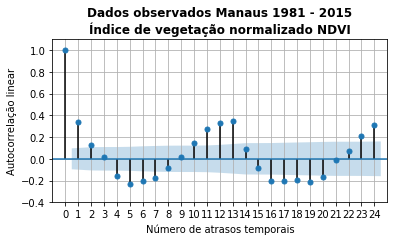

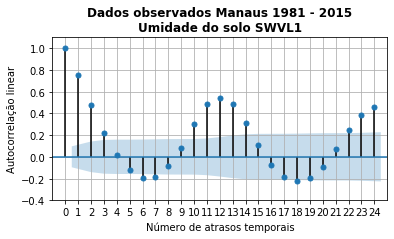

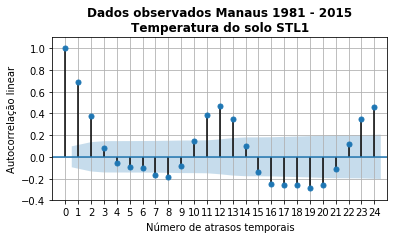

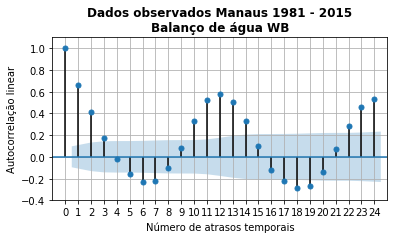

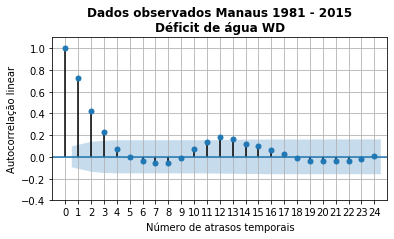

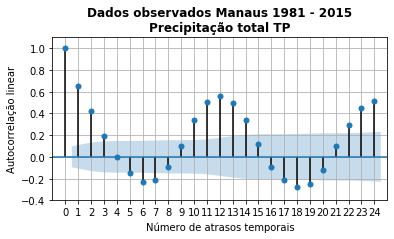

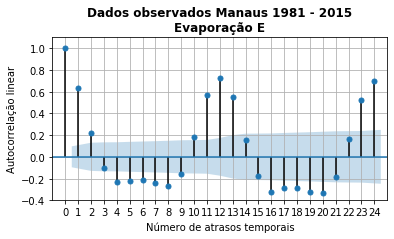

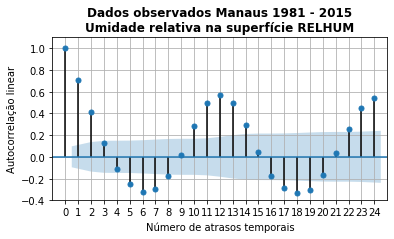

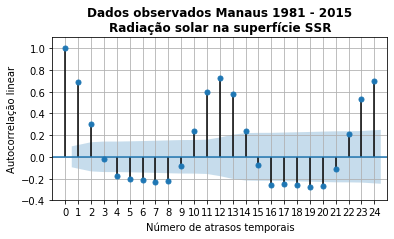

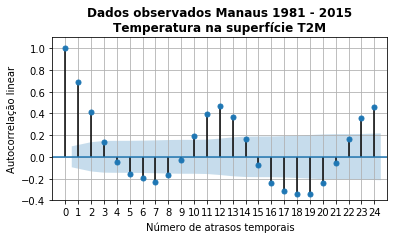

In [21]:
# Auto correlation plots.
for var_label, var_code in var_dict.items():

    cdlearn.plotting.autocorrelation(
        data_frame=df_local,
        var_label=var_label,
        lags=24,
        figsize=(6, 3),
        ylim=(-0.4, 1.1),
        xlabel="Número de atrasos temporais",
        ylabel="Autocorrelação linear",
        title="Dados observados Manaus 1981 - 2015\n" + dict_titles_pt[var_code]
    )
    
    # Save figures.
    plt.savefig(
        fig_path + "autocorrelation_" + var_dict[var_label] + "_" + location.lower() + \
        "_pt.jpg", dpi=200, bbox_inches="tight"
    )

### 4.3 Pair plots

CPU times: user 7.61 s, sys: 56.1 ms, total: 7.67 s
Wall time: 7.67 s


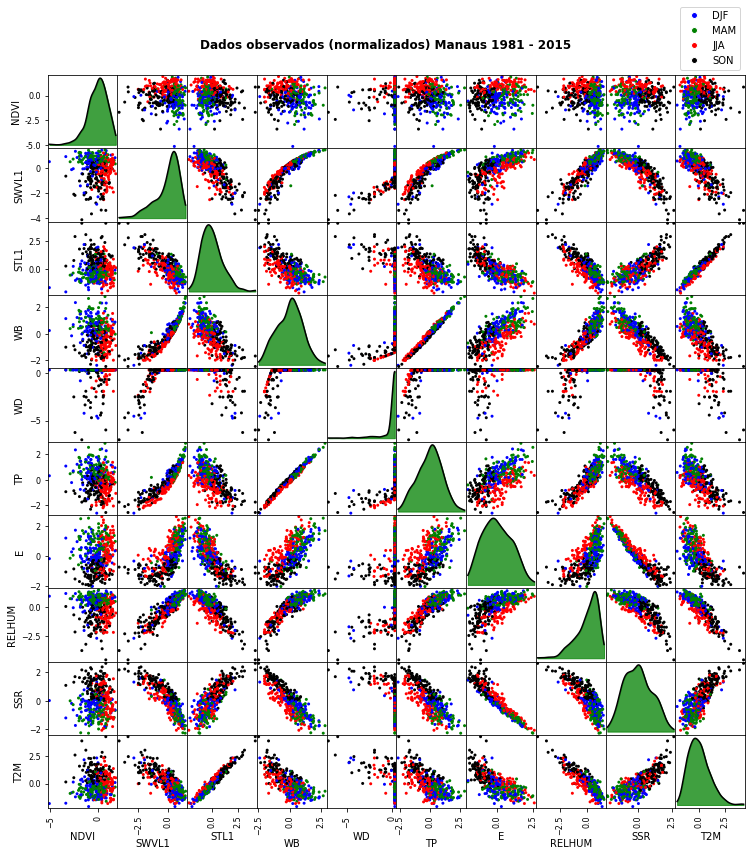

In [22]:
%%time

axes= cdlearn.plotting.pair_plot_mm(
    data_frame=df_local,
    standard_scaler=True,
    colorful=True,
    suptitle="Dados observados (normalizados) Manaus 1981 - 2015"
)

# Save figures.
plt.savefig(fig_path + "pair_plots_manaus_pt.jpg", dpi=200, bbox_inches="tight")